In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import re
from sklearn import preprocessing
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from tensorflow.python.client import device_lib
from keras.constraints import maxnorm
from keras.layers import Dropout
import time
import nltk
import warnings
warnings.filterwarnings("ignore")


In [40]:
df = pd.read_excel("C:/Users/jllce/Downloads/classificacao_assuntos.xlsx")

In [41]:
df.isnull().sum()

tweets    0
label     0
dtype: int64

In [42]:
# Se tiver valores nulos, usar o código abaixo

# df = df[~df['label'].isnull()]
# df

In [43]:
df1 = df["tweets"]
df2 = df["label"]

In [44]:
def cleanTxt(text):
  import re
  text = text.lower()
  text = re.sub(r"@([a-zA-Z0-9_]{1,50})",'',str(text)) 
  text = re.sub(r'(?:\@|https?\://)\S+','',text)
  text = re.sub(r'\d+','', text)
  text = re.sub(r"[-()\"#/;:<>{}-~=|.?,]","",text)
  return text

def removeEmojis(text):
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
        "]+", re.UNICODE)
  text = emoji_pattern.sub(r'', text)
  return text

def removeStopWords(text):
    stemmer = nltk.stem.RSLPStemmer()
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    words = [stemmer.stem(i) for i in text.split() if not i in stopwords]
    return (" ".join(words))


tweets_tratados = df1.apply(cleanTxt)
tweets_tratados = tweets_tratados.apply(removeEmojis)
tweets_tratados = tweets_tratados.apply(removeStopWords)
tweets = list(tweets_tratados)

In [45]:
tweets_tratados.isnull().sum()

0

In [46]:
label_encoder = preprocessing.LabelEncoder()
labels = pd.DataFrame(label_encoder.fit_transform(df2), columns=["Label"], index = df.index)
labels

,Label
0,2
1,1
2,1
3,1
4,0
...,...
18104,2
18105,2
18106,0
18107,3


In [47]:
labels.value_counts()

Label
2        8385
1        4819
3        2961
0        1944
dtype: int64

In [48]:
from keras.utils.np_utils import to_categorical
y = to_categorical(labels)

In [49]:
y.shape

(18109, 4)

In [50]:
# preparar tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)

In [51]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11579 unique tokens.


In [52]:
# integer codificar os documentos
sequences = tokenizer.texts_to_sequences(tweets)

In [53]:
# preencher documentos com um comprimento máximo de 28 palavras
maxlen = 28
X = pad_sequences(sequences, maxlen=maxlen)

In [54]:
X.shape

(18109, 28)

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [56]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12676, 28), (5433, 28), (12676, 4), (5433, 4))

In [57]:
# SimpleRNN
vocab_size = len(word_index) + 1
output_dim = 32
maxlen = maxlen
model = Sequential()
model.add(Embedding(vocab_size, output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(SimpleRNN(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim))
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [58]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 28, 32)            370560    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 28, 32)            2080      
                                                                 
 dropout_4 (Dropout)         (None, 28, 32)            0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 28, 32)            2080      
                                                                 
 dropout_5 (Dropout)         (None, 28, 32)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 4)                

In [59]:
model.save('srnn.h5')

In [60]:
start = time.time()

# Ajustar o modelo ao conjunto de treino
rnn_hist = model.fit(X_train, y_train, epochs=10, validation_split=0.3)
# Avaliação final do modelo
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
warnings.filterwarnings("ignore")

end = time.time()
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

Epoch 1/10
278/278 [==============================] - 15s 34ms/step - loss: 0.9806 - accuracy: 0.6159 - val_loss: 0.8026 - val_accuracy: 0.7039
Epoch 2/10
278/278 [==============================] - 8s 30ms/step - loss: 0.6412 - accuracy: 0.7702 - val_loss: 0.7012 - val_accuracy: 0.7478
Epoch 3/10
278/278 [==============================] - 8s 29ms/step - loss: 0.4299 - accuracy: 0.8520 - val_loss: 0.7045 - val_accuracy: 0.7594
Epoch 4/10
278/278 [==============================] - 9s 32ms/step - loss: 0.2994 - accuracy: 0.9033 - val_loss: 0.7881 - val_accuracy: 0.7560
Epoch 5/10
278/278 [==============================] - 9s 32ms/step - loss: 0.2202 - accuracy: 0.9315 - val_loss: 0.9260 - val_accuracy: 0.7305
Epoch 6/10
278/278 [==============================] - 7s 27ms/step - loss: 0.1829 - accuracy: 0.9409 - val_loss: 0.9674 - val_accuracy: 0.7297
Epoch 7/10
278/278 [==============================] - 12s 44ms/step - loss: 0.1512 - accuracy: 0.9551 - val_loss: 1.0546 - val_accuracy: 0.72

In [61]:
model = Sequential()
model.add(Embedding(vocab_size,output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(LSTM(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(output_dim, kernel_constraint=maxnorm(3)))
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
warnings.filterwarnings("ignore")

In [62]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 28, 32)            370560    
                                                                 
 lstm_3 (LSTM)               (None, 28, 32)            8320      
                                                                 
 dropout_6 (Dropout)         (None, 28, 32)            0         
                                                                 
 lstm_4 (LSTM)               (None, 28, 32)            8320      
                                                                 
 dropout_7 (Dropout)         (None, 28, 32)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 4)                

In [63]:
model.save('lstm.h5')

In [64]:
start = time.time()
# Ajustar o modelo ao conjunto de treino
lstm_hist = model.fit(X_train, y_train, epochs=10, validation_split=0.3)
# avaliação final do modelo
warnings.filterwarnings("ignore")
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
warnings.filterwarnings("ignore")
end = time.time()
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

Epoch 1/10
278/278 [==============================] - 38s 59ms/step - loss: 0.9346 - accuracy: 0.6293 - val_loss: 0.7349 - val_accuracy: 0.7250
Epoch 2/10
278/278 [==============================] - 16s 56ms/step - loss: 0.6128 - accuracy: 0.7634 - val_loss: 0.6696 - val_accuracy: 0.7431
Epoch 3/10
278/278 [==============================] - 16s 58ms/step - loss: 0.4404 - accuracy: 0.8515 - val_loss: 0.5909 - val_accuracy: 0.8009
Epoch 4/10
278/278 [==============================] - 16s 56ms/step - loss: 0.3314 - accuracy: 0.8927 - val_loss: 0.6202 - val_accuracy: 0.7920
Epoch 5/10
278/278 [==============================] - 16s 56ms/step - loss: 0.2785 - accuracy: 0.9140 - val_loss: 0.7006 - val_accuracy: 0.7849
Epoch 6/10
278/278 [==============================] - 17s 62ms/step - loss: 0.2480 - accuracy: 0.9200 - val_loss: 0.7104 - val_accuracy: 0.7733
Epoch 7/10
278/278 [==============================] - 17s 61ms/step - loss: 0.2283 - accuracy: 0.9293 - val_loss: 0.6879 - val_accuracy:

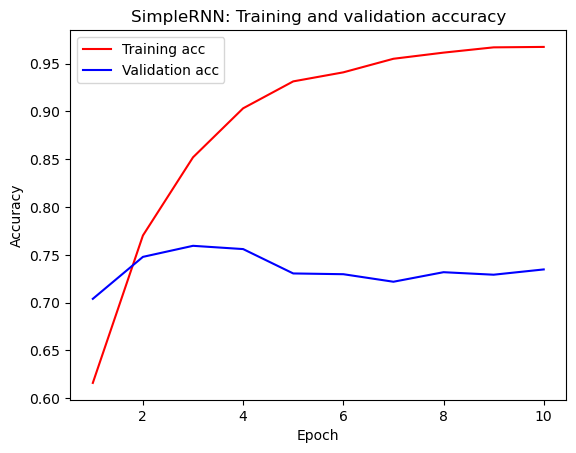

In [65]:
# SimpleRNN Result

acc = rnn_hist.history['accuracy']
val_acc = rnn_hist.history['val_accuracy']
loss = rnn_hist.history['loss']
val_loss = rnn_hist.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('SimpleRNN: Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

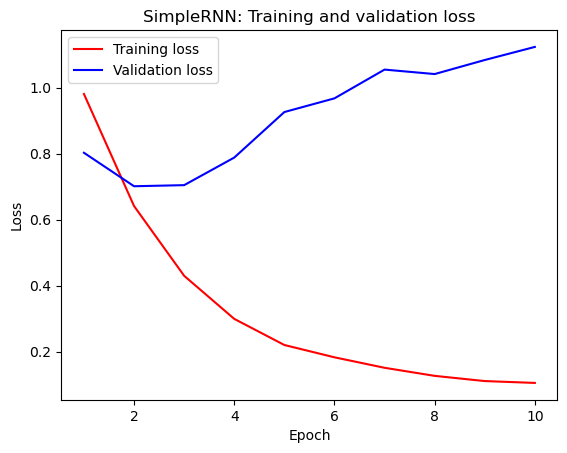

In [66]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('SimpleRNN: Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

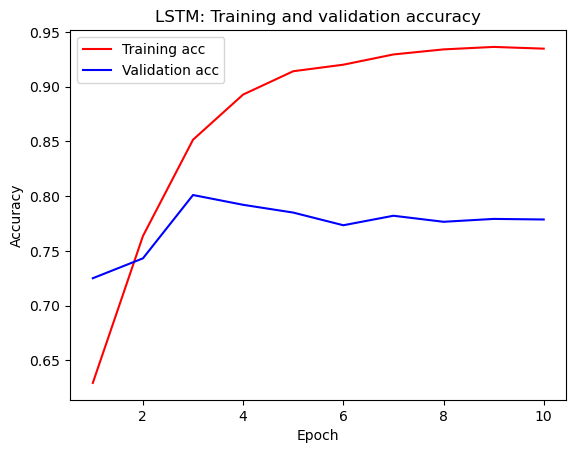

In [67]:
# LSTM Result

acc = lstm_hist.history['accuracy']
val_acc = lstm_hist.history['val_accuracy']
loss = lstm_hist.history['loss']
val_loss = lstm_hist.history['val_loss']
epochs = range(1, len(acc)+1)
_ = plt.plot(epochs, acc, 'r', label='Training acc')
_ = plt.plot(epochs, val_acc, 'b', label='Validation acc')
_ = plt.title('LSTM: Training and validation accuracy')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend(loc='best')
plt.show()

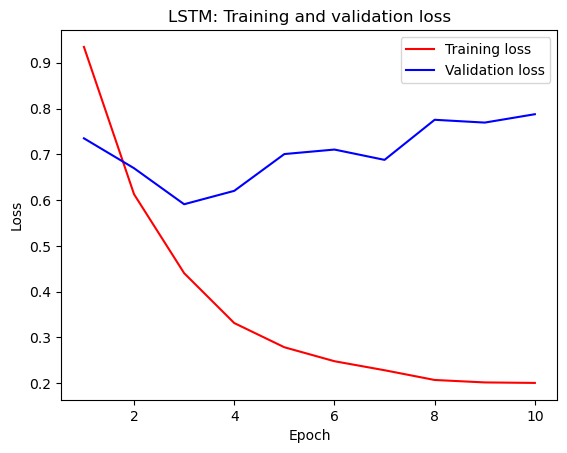

In [68]:
_ = plt.plot(epochs, loss, 'r', label='Training loss')
_ = plt.plot(epochs, val_loss, 'b', label='Validation loss')
_ = plt.title('LSTM: Training and validation loss')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend(loc='best')
plt.show()

In [69]:
from keras.models import load_model
lstm = load_model('lstm.h5')
warnings.filterwarnings("ignore")

In [70]:
lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 28, 32)            370560    
                                                                 
 lstm_3 (LSTM)               (None, 28, 32)            8320      
                                                                 
 dropout_6 (Dropout)         (None, 28, 32)            0         
                                                                 
 lstm_4 (LSTM)               (None, 28, 32)            8320      
                                                                 
 dropout_7 (Dropout)         (None, 28, 32)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 4)                

In [71]:
predictions = lstm.predict(X_test)

170/170 [==============================] - 4s 15ms/step
